# Experiment: RPCA vs. Matrix Completion Techniques
# Steam Games Dataset

### Neil Menghani and Jeffrey Tumminia

### Required Packages:

- cvxpy
- matrix_completion
- fancyimpute
- CVXOPT
- pylab
- seaborn
- rpca.py file provided; Source: https://github.com/dganguli/robust-pca

In [69]:
import numpy as np
import pandas as pd
import matrix_completion as mc
from pylab import plt
from rpca import R_pca
import seaborn as sns

### Load and Clean Steam Dataset

In [87]:
steam_df = pd.read_csv("steam-200k.csv", header=None, names=['user_id', 'game', 'behavior', 'hours', '0']).drop('0', axis=1)

In [89]:
top_games_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_games_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 100]
top_games = list(top_games_df.index)
top_users_df = steam_df.loc[(steam_df['behavior'] == 'play') & (steam_df['game'].isin(top_games))]
top_users_df = top_users_df.groupby('user_id').agg({'game':'count'}).sort_values('game', ascending=False)
top_users_df = top_users_df.loc[top_users_df['game'] >= 25]
top_users = list(top_users_df.index)
top_users_df

,game
user_id,
49893565,84
55906572,73
11403772,69
48798067,68
36546868,64
...,...
126269125,25
63615483,25
152419713,25


In [4]:
steam_df = steam_df.loc[(steam_df['game'].isin(top_games)) & (steam_df['user_id'].isin(top_users))]
purchase_df = steam_df.loc[steam_df['behavior'] == 'purchase']
play_df = steam_df.loc[steam_df['behavior'] == 'play']
print(len(purchase_df), len(play_df))

9969 8009


In [5]:
users = list(steam_df['user_id'].unique())
games = list(steam_df['game'].unique())
users.sort()
games.sort()
print("Unique Users: {}, Unique Games: {}".format(len(users), len(games)))

Unique Users: 223, Unique Games: 133


In [56]:
np.random.seed(1600)
THRESHOLD = 0.1
play_df['dataset'] = np.random.rand(len(play_df))
play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')

<ipython-input-56-dd619aff5a0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['dataset'] = np.random.rand(len(play_df))
<ipython-input-56-dd619aff5a0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')


In [109]:
OUTLIER_THRESHOLD = 0.1
play_df['outlier'] = np.random.rand(len(play_df))
play_df['outlier'] = play_df.apply(lambda x : 1 if ((x['outlier'] < OUTLIER_THRESHOLD) and (x['dataset'] == 'train')) else 0, axis=1)
play_df

,user_id,game,behavior,hours,dataset,outlier
134,53875128,Grand Theft Auto V,play,86.0,train,0
136,53875128,Insurgency,play,72.0,train,0
138,53875128,Left 4 Dead 2,play,71.0,train,1
146,53875128,Saints Row The Third,play,35.0,train,0
148,53875128,Far Cry 3,play,35.0,train,0
...,...,...,...,...,...,...
199704,135400225,Mount & Blade Warband,play,1.2,train,0
199710,135400225,Star Wars - Battlefront II,play,1.1,train,0
199724,135400225,Garry's Mod,play,0.8,test,0
199728,135400225,Loadout,play,0.8,train,0


### Generate Collaborative Filtering Matrix

In [165]:
A = np.zeros((len(users), len(games))) # hours played of games by users
A_outliers = np.zeros((len(users), len(games))) # hours played of games by users
B = np.zeros((len(users), len(games))) # binary matrix specifying known vs. unknown
test_coords = {} # matrix coordinates : hours_played for test data
for i in range(len(users)):
    user = users[i]
    # print(i)
    purchased = purchase_df.loc[purchase_df['user_id'] == user]['game'].unique()
    user_play_df = play_df.loc[play_df['user_id'] == user]
    played = user_play_df['game'].unique()
    hours_played = pd.Series(user_play_df.hours.values, index=user_play_df.game).to_dict()
    dataset = pd.Series(user_play_df.dataset.values, index=user_play_df.game).to_dict()
    outlier = pd.Series(user_play_df.outlier.values, index=user_play_df.game).to_dict()
    for j in range(len(games)):
        game = games[j]
        if game in played:
            if dataset[game] == 'train':
                if outlier[game] > 0:
                    sign = -1 if np.random.randint(2) else 1
                    A_outliers[i, j] = sign * np.random.uniform(1000, 10000)
                else:
                    A_outliers[i, j] = sign * np.random.uniform(1000, 10000)
                A[i, j] = hours_played[game]
                B[i, j] = 1
            else:
                test_coords[(i, j)] = hours_played[game]

In [169]:
np.save('steam.npy', A)
np.save('steam_outliers.npy', A_outliers)
np.save('missing.npy', B)

In [170]:
A_outliers.shape

(223, 133)

In [171]:
# Center Matrices
A_mean = np.tile(np.mean(A, axis=1), (A.shape[1], 1)).T
A_centered = A - A_mean
A_outliers_mean = np.tile(np.mean(A_outliers, axis=1), (A_outliers.shape[1], 1)).T
A_outliers_centered = A_outliers - A_outliers_mean

In [60]:
rpca = R_pca(A_centered)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 39.681222091932774
iteration: 100, error: 1.6165670541887385
iteration: 200, error: 1.193692331238148
iteration: 300, error: 0.9521524214616774
iteration: 400, error: 0.5907982393912963
iteration: 500, error: 0.4115142312091405
iteration: 600, error: 0.32720843631513713
iteration: 700, error: 0.1433057540668483
iteration: 800, error: 0.14101398575895543
iteration: 900, error: 0.09207050184374352
iteration: 1000, error: 0.07626738357820781
iteration: 1100, error: 0.06375373196912174
iteration: 1200, error: 0.0529068265248956
iteration: 1300, error: 0.05407201510902689
iteration: 1400, error: 0.05163814266092416
iteration: 1500, error: 0.05982186426547346
iteration: 1600, error: 0.05423951826471337
iteration: 1700, error: 0.06109239876227055
iteration: 1800, error: 0.06580548196361566
iteration: 1900, error: 0.05131102861390799
iteration: 2000, error: 0.04839168771046229
iteration: 2100, error: 0.053512880451486534
iteration: 2200, error: 0.049306316657851866
iterati

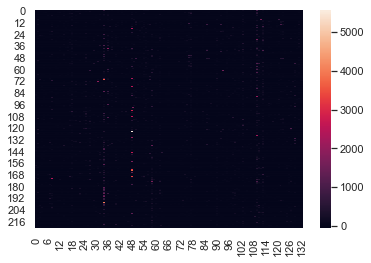

In [173]:
sns.set_theme()
ax = sns.heatmap(A_centered)

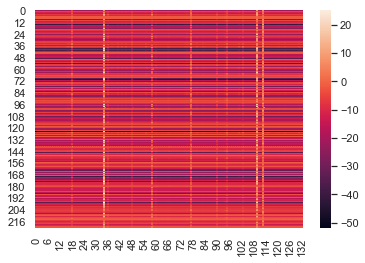

In [62]:
ax = sns.heatmap(L)

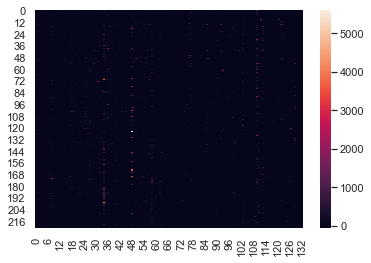

In [63]:
ax = sns.heatmap(S)

In [ ]:
# np.unravel_index(np.argmax(a, axis=None), a.shape)

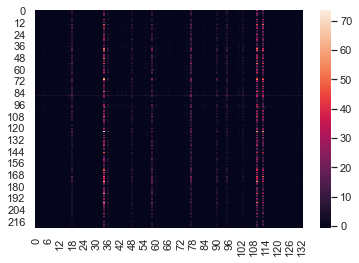

In [64]:
ax = sns.heatmap(L + A_mean)

In [172]:
rpca = R_pca(A_outliers_centered)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 928.597379135252
iteration: 100, error: 1.893567892874147
iteration: 200, error: 10.41763779896563
iteration: 300, error: 7.407162239584753
iteration: 400, error: 9.009917151071441
iteration: 500, error: 8.07852004907379
iteration: 600, error: 7.077997932103306
iteration: 700, error: 6.101403944276613
iteration: 800, error: 6.0731160696063435
iteration: 900, error: 5.136311884626843
iteration: 1000, error: 5.050329274811857
iteration: 1100, error: 4.509230613195384
iteration: 1200, error: 4.776098478705616
iteration: 1300, error: 3.0579910792812806
iteration: 1400, error: 4.079224246756784
iteration: 1500, error: 2.379007413858755
iteration: 1600, error: 2.6419596767815863
iteration: 1700, error: 1.8077081636128736
iteration: 1800, error: 2.3839860920593807
iteration: 1900, error: 2.192171721757786
iteration: 2000, error: 0.6549509090602693
iteration: 2100, error: 0.9436281256178272
iteration: 2200, error: 0.8449058345672088
iteration: 2300, error: 0.52755529990893

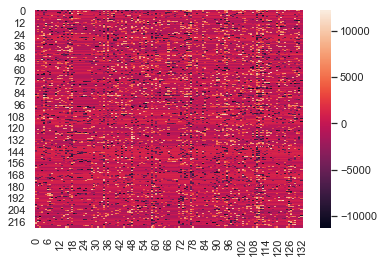

In [174]:
sns.set_theme()
ax = sns.heatmap(A_outliers_centered)

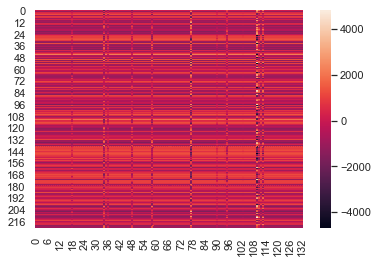

In [175]:
sns.set_theme()
ax = sns.heatmap(L)

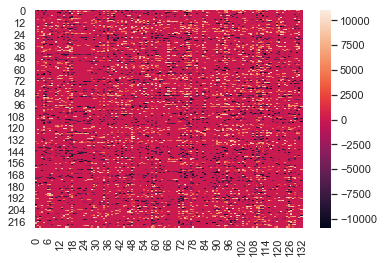

In [176]:
sns.set_theme()
ax = sns.heatmap(S)

In [187]:
def calc_rmse(coords, A_filled):
    total_error = 0
    for coord in coords:
        i, j = coord[0], coord[1]
        hours_pred = A_filled[i, j]
        hours_true = test_coords[coord]
        total_error += (hours_pred - hours_true)**2
        # print(hours_pred, hours_true)
    RMSE = np.sqrt(total_error / len(coords))
    return RMSE
calc_rmse(test_coords.keys(), L + A_outliers_mean)

595.0238532525276

### matrix_completion

- NuclearNorm
- Probabilistic Matrix Factorization with ALS

In [178]:
#% of values present
sum(sum(B))/(B.shape[0]*B.shape[1])

0.24286051451498702

In [179]:
A_centered

array([[-20.79172932,  20.20827068, -20.79172932, ..., -20.39172932,
          4.20827068, -20.79172932],
       [ -5.1556391 ,  -5.1556391 ,  -5.1556391 , ...,  -5.1556391 ,
         -5.1556391 ,  -5.1556391 ],
       [-11.29097744, -11.29097744, -11.29097744, ..., -11.29097744,
         29.70902256, -11.29097744],
       ...,
       [ -1.7481203 ,  -1.7481203 ,  -1.7481203 , ...,  -1.7481203 ,
         -1.7481203 ,  -1.7481203 ],
       [ -9.33909774,  -5.73909774,  -9.33909774, ...,  -9.33909774,
         -9.33909774,  -9.33909774],
       [ -2.19398496,  -2.19398496,  17.80601504, ...,  -2.19398496,
         -2.19398496,  -2.19398496]])

In [91]:
m = 1/np.sqrt(max(A_centered.shape))
R_hat = mc.nuclear_norm_solve(A_centered, B, mu=m)

(223, 133)


array([[  0.549593  ,  40.99534256,  59.83707752, ...,   0.40604708,
         25.01178622,  49.08579328],
       [ 42.82940143,  12.98406924,  10.70879462, ...,  22.10209812,
         -0.83643633, -10.64349271],
       [ 29.12222245,  38.65146504,   9.68289263, ...,  14.2403004 ,
         40.99616954,  17.23526226],
       ...,
       [ -0.68987246,   5.11156018,  -2.29555717, ...,   5.97407843,
         -1.41296466,   0.21226774],
       [ 44.72142387,   3.60107328, -29.49505082, ...,  22.75380575,
         26.51582535,  20.02081966],
       [ -1.57593185,   3.28766835,  19.99412395, ...,  -2.72761541,
         -9.37321797,  -0.56749225]])

In [180]:
m = 1/np.sqrt(max(A_outliers_centered.shape))
R_outliers_hat = mc.nuclear_norm_solve(A_outliers_centered, B, mu=m)

In [181]:
R_outliers_hat + A_outliers_mean

array([[-2.63018838e+03, -9.52836595e+03, -6.28140357e+03, ...,
         8.49336708e+03,  6.20047008e+03,  3.99100863e+03],
       [ 2.06234984e+03,  2.66452648e+03,  2.70139088e+03, ...,
         2.05122248e+03,  2.23367065e+03,  4.47945749e+03],
       [-3.77366609e+03, -2.24444786e+03, -4.67257427e+03, ...,
         4.29641789e+03,  2.27870491e+03,  2.48815872e+03],
       ...,
       [ 1.38307244e+02,  4.21172710e+03,  2.34504845e+03, ...,
         2.90669992e+03,  2.74528117e+03,  7.35900283e+02],
       [ 4.20656326e+03,  6.14390529e+03,  4.84052697e+03, ...,
         2.27992385e+03,  9.04218296e+02, -1.93998867e+03],
       [ 2.14970547e+03,  1.69857971e+03,  5.86448367e+03, ...,
        -2.08872042e+03,  5.34382452e+00,  7.98119036e+02]])

In [96]:
L + A_mean

array([[ 5.79951095e-06,  4.30834256e-05, -8.72300435e-06, ...,
         1.06301781e-05,  2.09060693e+00,  1.28952423e-05],
       [-1.73112744e-06, -4.82369748e-06,  2.88991756e-06, ...,
         2.65130965e-06,  7.64395750e-06,  5.77437907e-06],
       [ 8.65735843e-06, -1.66286465e-06,  3.94892906e-06, ...,
        -1.36833067e-06,  7.96427059e-01,  6.42016560e-06],
       ...,
       [-3.85059916e-06, -1.07480190e-05, -6.10251285e-07, ...,
        -1.58005616e-06,  6.64042507e-06,  1.23914751e-06],
       [ 4.75583534e-06,  4.02674727e-05, -3.15851810e-06, ...,
         4.16707086e-06, -4.41919848e-06,  5.81974690e-06],
       [ 1.86362139e-06,  3.93997961e-06,  1.10342313e-05, ...,
        -5.40426511e-07, -1.49275307e-05,  8.73867810e-06]])

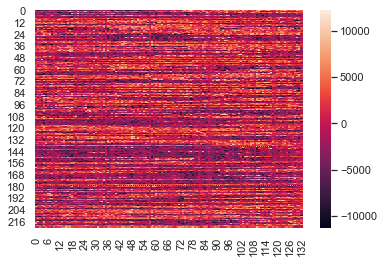

In [184]:
sns.heatmap(R_outliers_hat)

In [182]:
calc_rmse(test_coords.keys(), R_outliers_hat + A_outliers_mean)

4050.7770365116985